In [1]:
%pip install transformers datasets seqeval scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4f9e5d4bce07f9398cc63c51c770e4059f15d291bda5caa64fb05cae3f6af509
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_semeval_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []

    for sentence in root.iter('sentence'):
        sent_id = sentence.get('id')
        text = sentence.find('text').text
        aspects = sentence.find('aspectTerms')

        aspect_terms = []
        polarities = []
        if aspects:
            for aspect in aspects.findall('aspectTerm'):
                aspect_terms.append(aspect.get('term'))
                polarities.append(aspect.get('polarity'))

        data.append({
            'id': sent_id,
            'sentence': text,
            'aspect_terms': aspect_terms,
            'polarities': polarities
        })

    return pd.DataFrame(data)

In [6]:
restaurant_df = parse_semeval_xml('/content/Restaurants_Train_v2.xml')
laptop_df = parse_semeval_xml('/content/Laptop_Train_v2.xml')
combined_df = pd.concat([restaurant_df, laptop_df], ignore_index=True)


In [7]:
print(combined_df.iloc[7])

id                                                           1458
sentence        Our agreed favorite is the orrechiete with sau...
aspect_terms    [orrechiete with sausage and chicken, waiters,...
polarities                 [positive, positive, neutral, neutral]
Name: 7, dtype: object


# Step 2: Preprocess for Aspect Term Extraction (ATE)

In [8]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_and_label(sentence, aspect_terms):
    tokens = word_tokenize(sentence)
    labels = ['O'] * len(tokens)
    for aspect in aspect_terms:
        aspect_tokens = word_tokenize(aspect)
        for i in range(len(tokens) - len(aspect_tokens) + 1):
            if tokens[i:i+len(aspect_tokens)] == aspect_tokens:
                labels[i] = 'B-ASPECT'
                for j in range(1, len(aspect_tokens)):
                    labels[i + j] = 'I-ASPECT'
                break
    return tokens, labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
ate_data = [
    {'tokens': tokenize_and_label(row['sentence'], row['aspect_terms'])[0],
     'labels': tokenize_and_label(row['sentence'], row['aspect_terms'])[1]}
    for _, row in combined_df.iterrows()
]
ate_df = pd.DataFrame(ate_data)


# Step 3: Preprocess for Aspect Sentiment Classification (ASC)

In [10]:
asc_data = [
    {'sentence': row['sentence'], 'aspect': aspect, 'polarity': polarity}
    for _, row in combined_df.iterrows()
    for aspect, polarity in zip(row['aspect_terms'], row['polarities'])
]
asc_df = pd.DataFrame(asc_data)

# Step 4: Convert Data to Hugging Face Dataset Format

In [11]:
from datasets import Dataset
ate_dataset = Dataset.from_pandas(ate_df)
asc_dataset = Dataset.from_pandas(asc_df)

# Step 5: Tokenize the Data

In [12]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
label2id = {'O': 0, 'B-ASPECT': 1, 'I-ASPECT': 2}
id2label = {v: k for k, v in label2id.items()}

from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
label2id = {'O': 0, 'B-ASPECT': 1, 'I-ASPECT': 2}
id2label = {v: k for k, v in label2id.items()}

def preprocess_ate(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True,
        return_offsets_mapping=True,
    )

    all_labels = []
    for batch_index, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        original_labels = examples["labels"][batch_index]
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  # ignore special tokens
            elif word_idx != previous_word_idx:
                aligned_labels.append(label2id.get(original_labels[word_idx], 0))  # B- or I-ASPECT
            else:
                aligned_labels.append(-100)  # subword token
            previous_word_idx = word_idx

        # Padding to match max_length
        aligned_labels = aligned_labels[:128]
        aligned_labels += [-100] * (128 - len(aligned_labels))
        all_labels.append(aligned_labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


ate_dataset = ate_dataset.map(preprocess_ate, batched=True)


Map:   0%|          | 0/6086 [00:00<?, ? examples/s]

In [13]:
def preprocess_asc(examples):
    text = [f"{s} [SEP] {a}" for s, a in zip(examples['sentence'], examples['aspect'])]
    labels = [0 if p == "negative" else 1 if p == "neutral" else 2 for p in examples['polarity']]
    tokenized = tokenizer(text, padding='max_length', truncation=True, max_length=128)
    tokenized['labels'] = labels
    return tokenized

asc_dataset = asc_dataset.map(preprocess_asc, batched=True)


Map:   0%|          | 0/6051 [00:00<?, ? examples/s]

In [14]:
print(ate_dataset[24])

{'tokens': ['I', 'will', 'be', 'going', 'back', 'very', 'soon', '.'], 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], 'input_ids': [101, 1045, 2097, 2022, 2183, 2067, 2200, 2574, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
print(asc_dataset[83])

{'sentence': 'I liked the beer selection!', 'aspect': 'beer selection', 'polarity': 'positive', 'input_ids': [101, 1045, 4669, 1996, 5404, 4989, 999, 102, 5404, 4989, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# Step 7: Split datasets
ate_dataset = ate_dataset.shuffle(seed=42)
train_ate_dataset = ate_dataset.select(range(0, int(0.9 * len(ate_dataset))))
eval_ate_dataset = ate_dataset.select(range(int(0.9 * len(ate_dataset)), len(ate_dataset)))

asc_dataset = asc_dataset.shuffle(seed=42)
train_asc_dataset = asc_dataset.select(range(0, int(0.9 * len(asc_dataset))))
eval_asc_dataset = asc_dataset.select(range(int(0.9 * len(asc_dataset)), len(asc_dataset)))


In [17]:
# def hide_labels_in_eval(dataset, label_column):
#     """
#     Function to hide labels in the evaluation dataset
#     by removing the label column before inference.
#     """
#     dataset = dataset.remove_columns([label_column])
#     return dataset

# # Apply to your evaluation datasets
# eval_ate_dataset = hide_labels_in_eval(eval_ate_dataset, 'labels')
# eval_asc_dataset = hide_labels_in_eval(eval_asc_dataset, 'polarity')


In [18]:
print(train_ate_dataset[0])
print(eval_ate_dataset[0])
print(train_asc_dataset[0])
print(eval_asc_dataset[0])

{'tokens': ['Upon', 'entering', ',', 'we', 'were', 'greeted', 'by', 'the', 'owners', ',', 'Steven', 'and', 'Frederick', ',', 'who', 'went', 'out', 'of', 'their', 'way', 'to', 'be', 'more', 'than', 'gracious', 'hosts', '.'], 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 1, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], 'input_ids': [101, 2588, 5738, 1010, 2057, 2020, 11188, 2011, 1996, 5608, 101

# Step 6: Set Up LoRA for Fine-Tuning

In [19]:
from peft import LoraConfig, get_peft_model
from transformers import BertForTokenClassification, AutoModelForSequenceClassification

ate_model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label2id), id2label=id2label, label2id=label2id)
ate_lora_model = get_peft_model(ate_model, LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1))

asc_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
asc_lora_model = get_peft_model(asc_model, LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1))


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 7: Fine-Tune the Models

In [28]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)


In [25]:
# ATE Metrics
import numpy as np
def compute_metrics_ate(p):
    preds = np.argmax(p.predictions, axis=-1).flatten()
    labels = p.label_ids.flatten()
    mask = labels != 0
    return dict(zip(['precision', 'recall', 'f1', 'accuracy'],
                    precision_recall_fscore_support(labels[mask], preds[mask], average='binary')[:3] +
                    (accuracy_score(labels[mask], preds[mask]),)))

ate_trainer = Trainer(
    model=ate_lora_model,
    args=TrainingArguments(output_dir="./results_ate", per_device_train_batch_size=16, per_device_eval_batch_size=16,
                           num_train_epochs=3, eval_strategy="epoch", save_strategy="epoch", logging_dir="./logs"),
    data_collator=DataCollatorForTokenClassification(tokenizer),
    train_dataset=train_ate_dataset,
    eval_dataset=eval_ate_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_ate
)


<ipython-input-25-4ac1e22c1fb9>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ate_trainer = Trainer(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [26]:
# Train
ate_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,No log
2,0.207100,No log
3,0.161200,No log


TrainOutput(global_step=1029, training_loss=0.1831847914685545, metrics={'train_runtime': 257.9949, 'train_samples_per_second': 63.687, 'train_steps_per_second': 3.988, 'total_flos': 1077072953386752.0, 'train_loss': 0.1831847914685545, 'epoch': 3.0})

In [30]:
# ASC Metrics
def compute_metrics_asc(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_matrix(labels, preds).tolist()
    }

asc_trainer = Trainer(
    model=asc_lora_model,
    args=TrainingArguments(output_dir="./results_asc", per_device_train_batch_size=16, per_device_eval_batch_size=16,
                           num_train_epochs=3, eval_strategy="epoch", logging_strategy="steps", logging_steps=10,
                           save_strategy="epoch", logging_dir="./logs"),
    data_collator=DefaultDataCollator(),
    train_dataset=train_asc_dataset,
    eval_dataset=eval_asc_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_asc
)

<ipython-input-30-536f2c810736>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  asc_trainer = Trainer(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [31]:
asc_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.949400,No log
2,0.928100,No log
3,0.767800,No log


TrainOutput(global_step=1023, training_loss=0.8872581616641256, metrics={'train_runtime': 258.8587, 'train_samples_per_second': 63.104, 'train_steps_per_second': 3.952, 'total_flos': 1078189173262080.0, 'train_loss': 0.8872581616641256, 'epoch': 3.0})

# Step 8: Evaluate the Models


In [32]:
# Evaluate the model on the evaluation dataset
ate_results = ate_trainer.evaluate()

print("ATE Evaluation Results:", ate_results)

ATE Evaluation Results: {'eval_runtime': 4.4341, 'eval_samples_per_second': 137.346, 'eval_steps_per_second': 8.796, 'epoch': 3.0}


In [33]:
asc_results = asc_trainer.evaluate()

print("ASC Evaluation Results:", asc_results)

ASC Evaluation Results: {'eval_runtime': 4.4125, 'eval_samples_per_second': 137.337, 'eval_steps_per_second': 8.612, 'epoch': 3.0}


In [34]:
# Check if 'loss' is being logged in the training process
for entry in ate_trainer.state.log_history:
    print(entry)

{'eval_runtime': 4.6473, 'eval_samples_per_second': 131.042, 'eval_steps_per_second': 8.392, 'epoch': 1.0, 'step': 343}
{'loss': 0.2071, 'grad_norm': 0.5380362868309021, 'learning_rate': 2.575315840621963e-05, 'epoch': 1.4577259475218658, 'step': 500}
{'eval_runtime': 4.5666, 'eval_samples_per_second': 133.358, 'eval_steps_per_second': 8.54, 'epoch': 2.0, 'step': 686}
{'loss': 0.1612, 'grad_norm': 1.06669020652771, 'learning_rate': 1.457725947521866e-06, 'epoch': 2.9154518950437316, 'step': 1000}
{'eval_runtime': 4.494, 'eval_samples_per_second': 135.514, 'eval_steps_per_second': 8.678, 'epoch': 3.0, 'step': 1029}
{'train_runtime': 257.9949, 'train_samples_per_second': 63.687, 'train_steps_per_second': 3.988, 'total_flos': 1077072953386752.0, 'train_loss': 0.1831847914685545, 'epoch': 3.0, 'step': 1029}
{'eval_runtime': 4.4341, 'eval_samples_per_second': 137.346, 'eval_steps_per_second': 8.796, 'epoch': 3.0, 'step': 1029}


In [35]:
# Check if eval_loss is available in ate_results
print(ate_results)
print(asc_results)

{'eval_runtime': 4.4341, 'eval_samples_per_second': 137.346, 'eval_steps_per_second': 8.796, 'epoch': 3.0}
{'eval_runtime': 4.4125, 'eval_samples_per_second': 137.337, 'eval_steps_per_second': 8.612, 'epoch': 3.0}


In [42]:
print(ate_lora_model)

PeftModel(
  (base_model): LoraModel(
    (model): BertForTokenClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, o

In [43]:
print(asc_lora_model)

PeftModel(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768

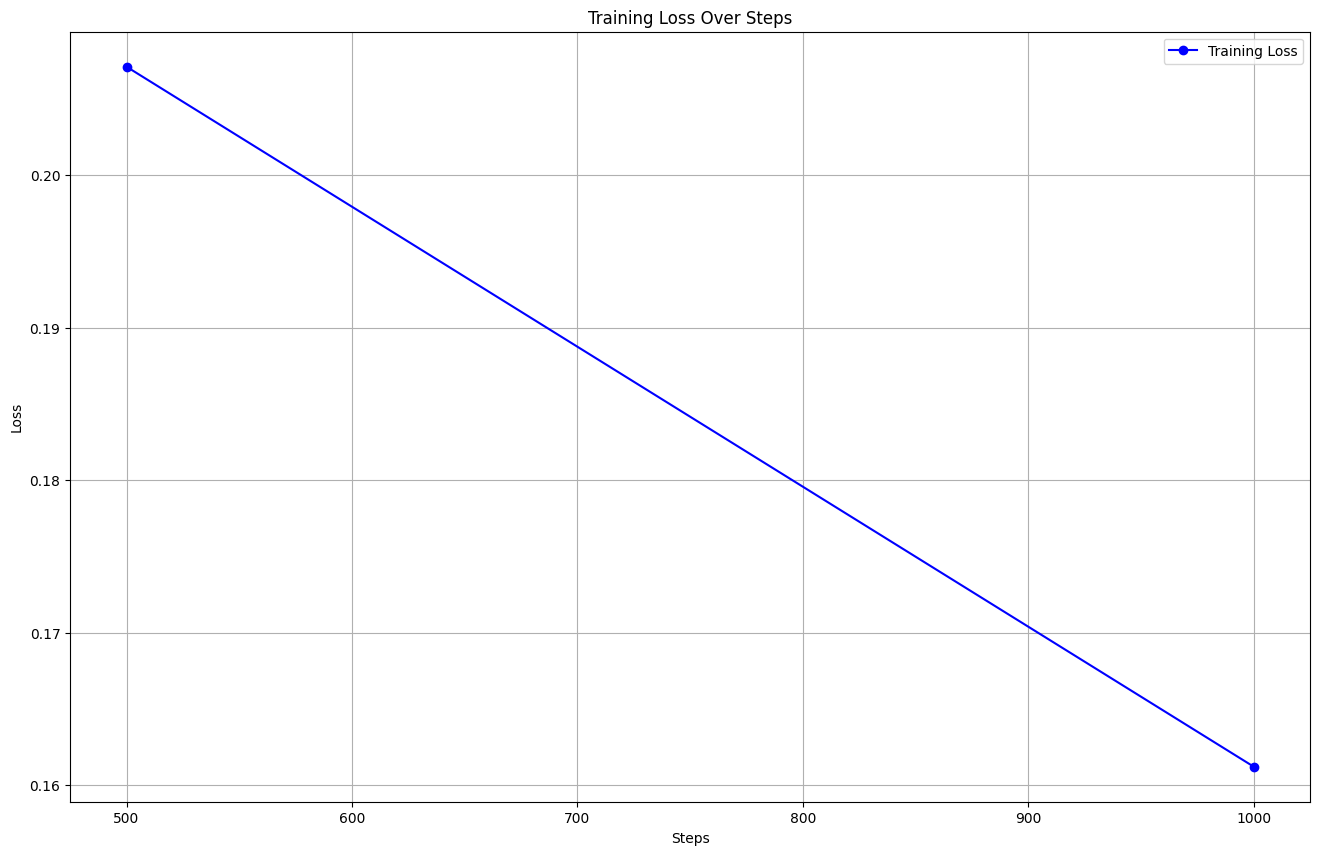

In [36]:
import matplotlib.pyplot as plt

# Example loss values over steps for visualization (replace with actual data)
train_losses = ate_trainer.state.log_history

# Extracting the loss values and corresponding steps
steps = []
losses = []

for entry in train_losses:
    if 'loss' in entry:  # Check if loss exists in the entry
        steps.append(entry['step'])
        losses.append(entry['loss'])

# Plotting the training loss
plt.figure(figsize=(16, 10))
plt.plot(steps, losses, label='Training Loss', color='blue', marker='o')

plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Step 9: Using the Models


In [39]:
import torch
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the models to the same device
ate_lora_model.to(device)
print('ate model to', device)
asc_lora_model.to(device)
print('asc model to', device)

ate model to cuda
asc model to cuda


In [55]:
def predict_ate(text, model, tokenizer, label_map, device):
    model.eval()

    # Tokenize
    encoded = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128,
        return_offsets_mapping=True,
        return_attention_mask=True
    )
    offset_mapping = encoded.pop('offset_mapping')
    inputs = {k: v.to(device) for k, v in encoded.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=-1).squeeze().cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze())
    offset_mapping = offset_mapping.squeeze().cpu().numpy()

    predicted_labels = []
    aligned_tokens = []

    for token, offset, pred_id in zip(tokens, offset_mapping, predictions):
        if offset[0] == 0 and offset[1] == 0:
            continue
        aligned_tokens.append(token)
        predicted_labels.append(label_map[pred_id])

    # Merge tokens into aspect terms properly
    aspect_terms = []
    current_aspect = []
    prev_label = 'O'

    for token, label in zip(aligned_tokens, predicted_labels):
        if label == 'B-ASPECT':
            if prev_label != 'O' and current_aspect:
                aspect_terms.append("".join(current_aspect).replace("##", ""))
                current_aspect = []
            current_aspect.append(token)
        elif label == 'I-ASPECT':
            if current_aspect:
                current_aspect.append(token)
        else:  # label == 'O'
            if current_aspect:
                aspect_terms.append("".join(current_aspect).replace("##", ""))
                current_aspect = []
        prev_label = label

    if current_aspect:
        aspect_terms.append("".join(current_aspect).replace("##", ""))

    return aligned_tokens, predicted_labels, aspect_terms


In [63]:
test_sentences = [
    "The pizza was delicious but the service was bad",
    "The vibe was awesome",
    "The burger was too salty"
]

for sentence in test_sentences:
    tokens, labels, aspects = predict_ate(sentence, ate_lora_model, tokenizer, id2label, device)
    print(f"Sentence: {sentence}")
    print("Tokens:", tokens)
    print("Labels:", labels)
    print("Extracted Aspect Terms:", aspects)
    print("-" * 50)



Sentence: The pizza was delicious but the service was bad
Tokens: ['the', 'pizza', 'was', 'delicious', 'but', 'the', 'service', 'was', 'bad']
Labels: ['O', 'B-ASPECT', 'O', 'O', 'O', 'O', 'B-ASPECT', 'O', 'O']
Extracted Aspect Terms: ['pizza', 'service']
--------------------------------------------------
Sentence: The vibe was awesome
Tokens: ['the', 'vibe', 'was', 'awesome']
Labels: ['O', 'B-ASPECT', 'O', 'O']
Extracted Aspect Terms: ['vibe']
--------------------------------------------------
Sentence: The burger was too salty
Tokens: ['the', 'burger', 'was', 'too', 'salty']
Labels: ['O', 'B-ASPECT', 'O', 'O', 'O']
Extracted Aspect Terms: ['burger']
--------------------------------------------------


In [66]:
# Dummy APC model setup (replace with your actual model)
apc_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
apc_model = asc_lora_model
apc_model.eval()

# Sentiment map (adjust according to your model's output)
id2sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Predict sentiment for a given aspect term within its sentence
def predict_apc(sentence, aspect, model, tokenizer, device):
    # Format input as required by your model (e.g., "[CLS] sentence [SEP] aspect [SEP]")
    inputs = tokenizer(
        sentence,
        aspect,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1).item()

    return id2sentiment[pred]


In [68]:
predict_apc('The pizza was delicious but the service was bad',
            'pizza',
            asc_lora_model,
            tokenizer,
            device
            )

'positive'

In [69]:
def analyze_aspect_sentiments(text, ate_model, ate_tokenizer, apc_model, apc_tokenizer, device, label_map):
    # Step 1: ATE Prediction
    _, _, aspect_terms = predict_ate(text, ate_model, ate_tokenizer, label_map, device)

    # Step 2: APC for each aspect
    aspect_sentiments = {}
    for aspect in aspect_terms:
        sentiment = predict_apc(text, aspect, apc_model, apc_tokenizer, device)
        aspect_sentiments[aspect] = sentiment

    return aspect_sentiments

In [70]:
text = input()
analyze_aspect_sentiments(text, ate_lora_model, tokenizer, asc_lora_model, apc_tokenizer, device, id2label)

The pizza was delicious but the service was bad


{'pizza': 'positive', 'service': 'negative'}